In [48]:
import pandas as pd
import matplotlib.pyplot as plt

import yfinance as yf
import datetime


# 0. Functions

In [69]:

def daily_price(ticker, end, days_earlier=3, columns=['Close']):
    '''
    Returns a DataFrame of prices for ticker from Yahoo Finance API
    The close date is excluded!!!!
    Minimum 3 days window due to weekends and holidays.
    '''
    result_series = []

    for timestamp in end:
        start = timestamp - datetime.timedelta(days=days_earlier)

        obj = yf.Ticker(ticker)
        data = obj.history(start=start, end=timestamp)[columns]

        result_series.append(data[columns].values.mean())

    return pd.Series(result_series).values

In [72]:
def convert_national_currency(input_data=pd.DataFrame, currency=pd.DataFrame):
    '''
    Convert colums into national currency
    '''
    output_data = input_data.copy()

    for column in output_data.columns:
        if column not in ['shares', 'national_div', 'usd_div', 'usd_nat_currency', 'real_date', 'date']:
            output_data[column] = output_data[column].astype(float) * currency['usd_nat_currency']

    return output_data

In [51]:
def calculate_real_date(input):
    '''
    Calculate the rough estimated date when the quaterly report could be available
    '''
    result = []
    for timestamp in input['date']:
        if timestamp.month == 12:
            result.append(timestamp + datetime.timedelta(days=42))
        else:
            result.append(timestamp + datetime.timedelta(days=21))

    input['real_date'] = result
    return input

In [52]:
def filter_raw_data(input=pd.DataFrame):
    filtered = input[
                [
                'date',
                'real_date',
                'shares',
                'revenue',
                'cogs',
                'gross_profit',
                'net_profit',
                'cash',
                'acc_rec',
                'inventory',
                'curr_assets',
                'goodwill',
                'intangible_assets',
                'total_assets',
                'acc_pay',
                'short_term_debt',
                'current_debt',
                'curr_liab',
                'long_term_debt',
                'total_liab',
                'cash_from_operating_activities',
                'capex'
                ]
            ].copy()
    
    return filtered

In [53]:
def calculate_input_value_ratios(input=pd.DataFrame):
    input['eps'] = (input['net_profit'] * 4) / input['shares'] # quaterly corrected here --> multipled by 4
    input['bv_per_share'] = (input['total_assets']-input['total_liab']) / input['shares']
    input['fcf'] = (4 * input['cash_from_operating_activities']) - (input['capex'] * 4) # quaterly corrected here --> multipled by 4
    input['fcf_per_share'] = input['fcf'] / input['shares']

    return input

In [54]:
def ratios_input_filter(input=pd.DataFrame):
    ratios = input[
                [
                'date',
                'real_date',
                'revenue',
                'eps',
                'bv_per_share',
                'shares',
                'fcf',
                'fcf_per_share'
                ]
            ].copy()

    return ratios

In [55]:
def evaluate_performance(input=pd.DataFrame, output=pd.DataFrame):
    # evauleat short term debt
    output['current_ratio'] = input['curr_assets'] / input['curr_liab']
    output['quick_ratio'] = (input['curr_assets'] - input['inventory']) / input['curr_liab']
    output['cash_ratio'] = input['cash'] / input['curr_liab']
    #evaluate long term debt
    output['debt_to_equity'] = input['total_liab'] / (input['total_assets'] - input['total_liab'])
    output['equity_ratio'] = (input['total_assets'] - input['total_liab']) / input['total_assets']
    output['debt_ratio'] = input['total_liab'] / input['total_assets']
    # evlauate management --> based on efficiency ratios
    output['acc_rec_ratio'] = (4 * input['revenue']) / input['acc_rec']
    output['acc_pay_ratio'] = (-4 * input['cogs']) / input['acc_pay']
    output['cash_turnover'] = (4 * input['revenue']) / input['cash']
    output['inventory_turnover'] = (-4 * input['cogs']) / input['inventory']
    # test economy moat
    output['gross_profit_margin'] = input['gross_profit'] / input['revenue']
    output['net_profit_margin'] = input['net_profit'] / input['revenue']
    output['roa'] = (4 * input['net_profit']) / input['total_assets']
    output['roe'] = (4 * input['net_profit']) / (input['total_assets'] - input['total_liab'])

    return output

In [56]:
def price_ratios(input=pd.DataFrame):
    '''
    The original metrics have been develoed to annual data. I use quaterly data.
    '''
    input['pe_ratio'] = input['share_price'] / input['eps'] # previously multiplied by 4 (quaterly correction)
    input['pb_ratio'] = input['share_price'] / input['bv_per_share'] # don't need to quaterly correct (Income Statement data)
    input['ps_ratio'] = (input['share_price'] * input['shares']) / (input['revenue'] * 4) # quaterly corrected here --> multipled by 4
    input['pfcf_ratio'] = (input['share_price'] * input['shares']) / input['fcf']  # previously multiplied by 4 (quaterly correction)

    return input

# 1. Load raw input
## Hardcoded block

In [57]:
currency_pair = 'NOK=X'
share_name = 'LSG.OL'

# 1.1 Calculate Share numbers from total distributed dividend (CFS) and dividend amount
## Pull historical USD national currency rates to dividend & calculate historical dividend in USD

In [43]:
ticker_share = yf.Ticker(share_name)
dividend = ticker_share.history(period='max', interval="1wk")
dividend = dividend[dividend['Dividends'] > 0]
dividend = dividend.rename(columns={'Dividends': 'local_amount'})

dividend['real_date'] = dividend.index 
dividend['real_date'] = dividend['real_date'].dt.tz_localize(None)

dividend = dividend[['real_date', 'local_amount']]

dividend['usd_rate'] = daily_price(ticker=currency_pair, end=dividend['real_date'], days_earlier=3)
dividend['currency'] = [currency_pair.split(sep='=')[0] for x in range(len(dividend))]
dividend['usd_dividend'] = dividend['local_amount'] / dividend['usd_rate']

NOK=X: No price data found, symbol may be delisted (1d 2003-05-16 00:00:00 -> 2003-05-19 00:00:00)
/var/folders/ds/_qwh_w111nvcxm803f83zkjh0000gn/T/ipykernel_25631/3975615225.py:15: RuntimeWarning: Mean of empty slice.
  result_series.append(data[columns].values.mean())
/Users/zsolt.nagy/Desktop/projects/.venv/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [44]:
dividend.to_csv(f"../csv_files/{share_name}_dividend.csv")
dividend.head()

,real_date,local_amount,usd_rate,currency,usd_dividend
Date,,,,,
2003-05-19 00:00:00+02:00,2003-05-19,0.060,NaN,NOK,NaN
2004-05-24 00:00:00+02:00,2004-05-24,0.060,6.8727,NOK,0.008730
2005-05-23 00:00:00+02:00,2005-05-23,0.080,6.4594,NOK,0.012385
2006-05-22 00:00:00+02:00,2006-05-22,0.014,6.1060,NOK,0.002293
2007-05-21 00:00:00+02:00,2007-05-21,0.400,6.0416,NOK,0.066208


## Extend your input statement table with historical dividend data and calculate share prices!

# 1.2. Raw input statement data

In [65]:
route = f"../csv_files/{share_name}_data.csv"
data = pd.read_csv(route, sep=';', parse_dates=['date'])
# change , to . in shares number columns 
data['shares'] = data['shares'].str.replace(',', '.').astype(float)

data.tail()

,date,revenue,cogs,gross_profit,sell_gen_adm_exp,r&d,other_income,financial_income,profit_before_tax,tax,...,other_investing_cf_items,cash_from_investing,financing_cf_item,total_cash_dividend_paied,issuance_of_stocks,issuance_of_debt,cash_from_financing,foreign_exchange_effect,net_change_in_cash,shares
66,2022-09-30,7441,-4363,3078,-952,0,-1223,-114,790,-191,...,3,-181,-76,-1,0,-781,-858,0,-73,595.77
67,2022-12-31,7114,-3929,3185,-979,0,-1641,-194,370,-109,...,167,-137,-108,1,0,187,79,0,403,595.77
68,2023-03-31,6971,-3566,3406,-1122,0,-845,-105,1335,-302,...,-85,-349,-96,-1,0,99,1,0,280,595.77
69,2023-06-30,7668,-4321,3347,-961,0,-1440,-182,765,-201,...,14,-257,-116,-1526,0,1477,-165,0,241,595.77
70,2023-09-30,8001,-4849,3152,-1045,0,-2237,-211,-342,-55,...,-4,-322,-132,0,0,731,599,0,1345,595.77


## Calculate date when quaterly reports could be available

In [66]:
data = calculate_real_date(data)

# 2. Filter out unnecesary columns

In [67]:
data = filter_raw_data(data)
data.tail()

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,intangible_assets,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex
66,2022-09-30,2022-10-21,595.77,7441,-4363,3078,599,2902,2647,9974,...,8706,36840,2124,37,1614,5884,4997,17376,966,-184
67,2022-12-31,2023-02-11,595.77,7114,-3929,3185,261,3305,2717,9925,...,8550,37062,2077,0,2104,6363,4935,17353,461,-304
68,2023-03-31,2023-04-21,595.77,6971,-3566,3406,1033,3585,2621,10878,...,8704,38644,1932,15,2432,6692,4883,17818,628,-265
69,2023-06-30,2023-07-21,595.77,7668,-4321,3347,563,3826,2987,11073,...,8762,40124,2427,23,2206,6784,7002,21871,662,-270
70,2023-09-30,2023-10-21,595.77,8001,-4849,3152,-287,5170,2972,10684,...,8720,40838,2780,32,3148,7867,6916,23009,1068,-317


## Pull historical average USD national currency rates and add to the dataframe

In [70]:
data['usd_nat_currency'] = daily_price(
    ticker=currency_pair,
    end=data['date'],
    days_earlier=90
    )

# drop rows, when USD rates wasn't available
data = data[data['usd_nat_currency'].notna()]

data.tail()

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,usd_nat_currency
66,2022-09-30,2022-10-21,595.77,7441,-4363,3078,599,2902,2647,9974,...,36840,2124,37,1614,5884,4997,17376,966,-184,9.966961
67,2022-12-31,2023-02-11,595.77,7114,-3929,3185,261,3305,2717,9925,...,37062,2077,0,2104,6363,4935,17353,461,-304,10.186402
68,2023-03-31,2023-04-21,595.77,6971,-3566,3406,1033,3585,2621,10878,...,38644,1932,15,2432,6692,4883,17818,628,-265,10.221379
69,2023-06-30,2023-07-21,595.77,7668,-4321,3347,563,3826,2987,11073,...,40124,2427,23,2206,6784,7002,21871,662,-270,10.699984
70,2023-09-30,2023-10-21,595.77,8001,-4849,3152,-287,5170,2972,10684,...,40838,2780,32,3148,7867,6916,23009,1068,-317,10.483742


## Convert USD values related to IS, BS, CFS to national currency

In [73]:
# convert columns into national currency
data_nok = convert_national_currency(input_data=data, currency=data)
data_nok.tail()

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,usd_nat_currency
66,2022-09-30,2022-10-21,595.77,74164.158548,-43485.851867,30678.306681,5970.209780,28924.121503,26382.546389,99410.471356,...,367182.851890,21169.825663,368.777566,16086.675433,58645.599906,49804.905290,173185.918416,9628.084553,-1833.920867,9.966961
67,2022-12-31,2023-02-11,595.77,72466.061622,-40022.372240,32443.689383,2658.650841,33666.057585,27676.453392,101100.036773,...,377528.419434,21157.156310,0.000000,21432.189156,64816.073953,50269.892340,176764.628526,4695.931179,-3096.666114,10.186402
68,2023-03-31,2023-04-21,595.77,71253.230287,-36449.436122,34814.015544,10558.684104,36643.642315,26790.233336,111188.156515,...,394994.954987,19747.703474,153.320679,24858.392778,68401.465655,49910.991750,182124.524065,6419.025767,-2708.665332,10.221379
69,2023-06-30,2023-07-21,595.77,82047.475020,-46234.629572,35812.845448,6024.090824,40938.137640,31960.851315,118480.919522,...,429326.146023,25968.860443,246.099625,23604.164045,72588.689428,74921.285875,234019.343527,7083.389210,-2888.995599,10.699984
70,2023-09-30,2023-10-21,595.77,83880.420054,-50835.665147,33044.754907,-3008.833965,54200.946342,31157.681340,112008.299945,...,428135.057390,29144.802868,335.479745,33002.819939,82475.598621,72505.559942,241220.420576,11196.636498,-3323.346226,10.483742


# 3. Calculate input to Value Raios (eps, bv per share, fcf)
## filter out unwanted columns

In [74]:
filtered_nok = calculate_input_value_ratios(data_nok)

## Calculate input values to value ratios

In [75]:
ratios_nok = ratios_input_filter(filtered_nok)

In [76]:
ratios_nok = evaluate_performance(input=filtered_nok, output=ratios_nok)

# 4. Pull historical share prices and merge with sattement data
## Pull historical share prices

In [77]:

obj = yf.Ticker(share_name)
yar_share_price = obj.history(interval="1wk", start=data.date.min(), end=pd.Timestamp.now())
# add new date column due to pd.merge_asof match
yar_share_price['real_date'] = yar_share_price.index
# remove localization (timezone) to let merge the two columns
yar_share_price['real_date'] = yar_share_price['real_date'].dt.tz_localize(None)
# add share price column and keep the date and share prices
yar_share_price['share_price'] = yar_share_price['Close']
yar_share_price = yar_share_price[['real_date', 'share_price']]

yar_share_price.tail()

,real_date,share_price
Date,,
2024-01-08 00:00:00+01:00,2024-01-08,43.500000
2024-01-15 00:00:00+01:00,2024-01-15,43.860001
2024-01-22 00:00:00+01:00,2024-01-22,41.860001
2024-01-29 00:00:00+01:00,2024-01-29,42.000000
2024-02-05 00:00:00+01:00,2024-02-05,41.740002


## Merge the statement dataset with share prices

In [80]:
merged_nok = pd.merge_asof(left=yar_share_price, right=ratios_nok, on='real_date', direction='backward')
# drop rows with np.Nan and reset index
merged_nok = merged_nok.dropna()
merged_nok = merged_nok.reset_index(drop=True)
merged_nok.head()

,real_date,share_price,date,revenue,eps,bv_per_share,shares,fcf,fcf_per_share,current_ratio,...,equity_ratio,debt_ratio,acc_rec_ratio,acc_pay_ratio,cash_turnover,inventory_turnover,gross_profit_margin,net_profit_margin,roa,roe
0,2006-04-24,6.325020,2006-03-31,7427.387879,103.485193,227.542743,42.78,5973.913411,139.64267,2.5696,...,0.534799,0.465201,7.269168,inf,14.657895,4.894049,0.243268,0.149013,0.243223,0.454795
1,2006-05-01,6.556422,2006-03-31,7427.387879,103.485193,227.542743,42.78,5973.913411,139.64267,2.5696,...,0.534799,0.465201,7.269168,inf,14.657895,4.894049,0.243268,0.149013,0.243223,0.454795
2,2006-05-08,6.633554,2006-03-31,7427.387879,103.485193,227.542743,42.78,5973.913411,139.64267,2.5696,...,0.534799,0.465201,7.269168,inf,14.657895,4.894049,0.243268,0.149013,0.243223,0.454795
3,2006-05-15,5.656520,2006-03-31,7427.387879,103.485193,227.542743,42.78,5973.913411,139.64267,2.5696,...,0.534799,0.465201,7.269168,inf,14.657895,4.894049,0.243268,0.149013,0.243223,0.454795
4,2006-05-22,5.553673,2006-03-31,7427.387879,103.485193,227.542743,42.78,5973.913411,139.64267,2.5696,...,0.534799,0.465201,7.269168,inf,14.657895,4.894049,0.243268,0.149013,0.243223,0.454795


# Calculate price ratios (P/E, P/B, P/S, P/FCF)

In [81]:
merged_nok = price_ratios(merged_nok)
merged_nok.head()

,real_date,share_price,date,revenue,eps,bv_per_share,shares,fcf,fcf_per_share,current_ratio,...,cash_turnover,inventory_turnover,gross_profit_margin,net_profit_margin,roa,roe,pe_ratio,pb_ratio,ps_ratio,pfcf_ratio
0,2006-04-24,6.325020,2006-03-31,7427.387879,103.485193,227.542743,42.78,5973.913411,139.64267,2.5696,...,14.657895,4.894049,0.243268,0.149013,0.243223,0.454795,0.061120,0.027797,0.009108,0.045294
1,2006-05-01,6.556422,2006-03-31,7427.387879,103.485193,227.542743,42.78,5973.913411,139.64267,2.5696,...,14.657895,4.894049,0.243268,0.149013,0.243223,0.454795,0.063356,0.028814,0.009441,0.046951
2,2006-05-08,6.633554,2006-03-31,7427.387879,103.485193,227.542743,42.78,5973.913411,139.64267,2.5696,...,14.657895,4.894049,0.243268,0.149013,0.243223,0.454795,0.064101,0.029153,0.009552,0.047504
3,2006-05-15,5.656520,2006-03-31,7427.387879,103.485193,227.542743,42.78,5973.913411,139.64267,2.5696,...,14.657895,4.894049,0.243268,0.149013,0.243223,0.454795,0.054660,0.024859,0.008145,0.040507
4,2006-05-22,5.553673,2006-03-31,7427.387879,103.485193,227.542743,42.78,5973.913411,139.64267,2.5696,...,14.657895,4.894049,0.243268,0.149013,0.243223,0.454795,0.053666,0.024407,0.007997,0.039771


# Calculate Dividend yield and currency-share price correlation

In [82]:
obj = yf.Ticker(currency_pair)
obj2 = yf.Ticker(share_name)
usd_nok = obj.history(interval="1d", start=merged_nok['real_date'].min(), end=pd.Timestamp.now())
usd_nok['date'] = usd_nok.index
usd_nok['date'] = usd_nok['date'].dt.tz_localize(None)
usd_nok['currency_rate'] = usd_nok['Close']

In [83]:
yar_all_price = obj2.history(interval="1d", start=merged_nok['real_date'].min(), end=pd.Timestamp.now())
yar_all_price['date'] = yar_all_price.index
yar_all_price['date'] = yar_all_price['date'].dt.tz_localize(None)
yar_all_price['share_price'] = yar_all_price['Close']
yar_all_price['dividend_yield'] = yar_all_price['Dividends'] * 100 / yar_all_price['Close']

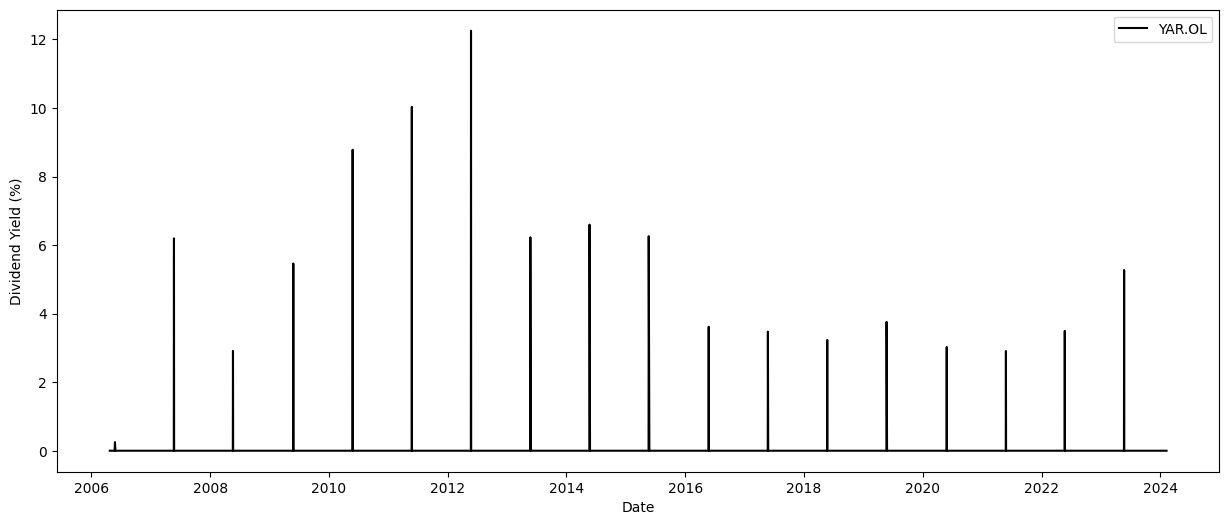

In [84]:
fig, ax1 = plt.subplots(figsize=(15, 6))

ax1.plot(yar_all_price.index, yar_all_price['dividend_yield'], color='k', label='YAR.OL')

ax1.set_xlabel('Date')
ax1.set_ylabel('Dividend Yield (%)', color='k')

plt.legend()
plt.show()

In [85]:
share_price_currency_rate_correlation = pd.merge_asof(left=usd_nok, right=yar_all_price, on='date')
share_price_currency_rate_correlation.index = share_price_currency_rate_correlation['date']
share_price_currency_rate_correlation = share_price_currency_rate_correlation[['currency_rate', 'share_price']]

share_price_currency_rate_correlation.corr()['share_price']

currency_rate    0.83572
share_price      1.00000
Name: share_price, dtype: float64

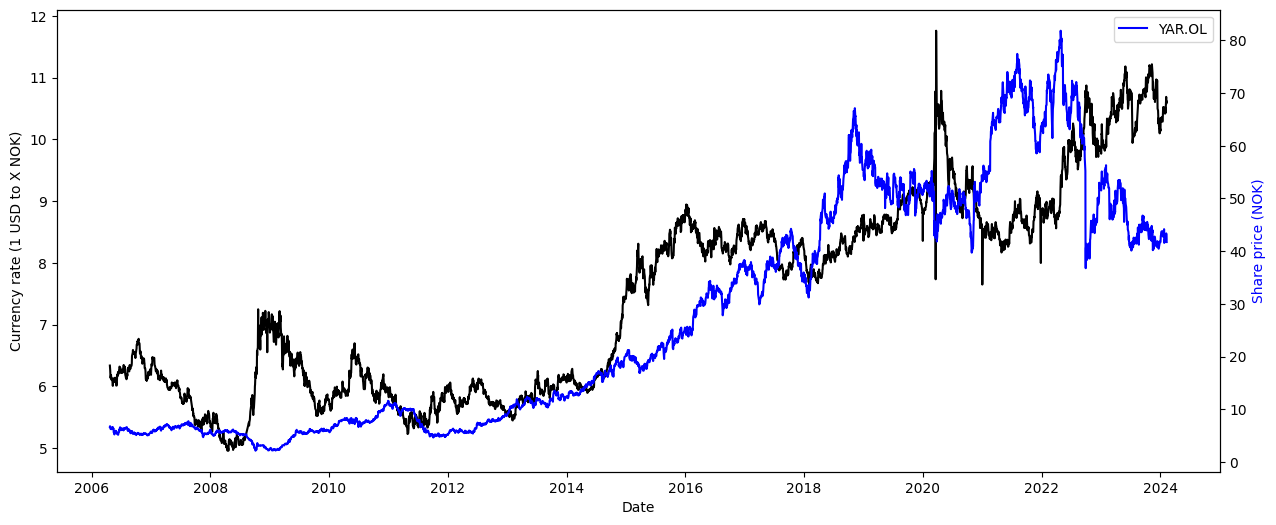

In [86]:
fig, ax1 = plt.subplots(figsize=(15, 6))

ax2 = ax1.twinx()
ax1.plot(usd_nok.index, usd_nok['Close'], color='k', label='USD / NOK')
ax2.plot(yar_all_price.index, yar_all_price['Close'], color='b', label='YAR.OL')

ax1.set_xlabel('Date')
ax1.set_ylabel('Currency rate (1 USD to X NOK)', color='k')
ax2.set_ylabel('Share price (NOK)', color='b')

plt.legend()
plt.show()

# Share price and value ratios

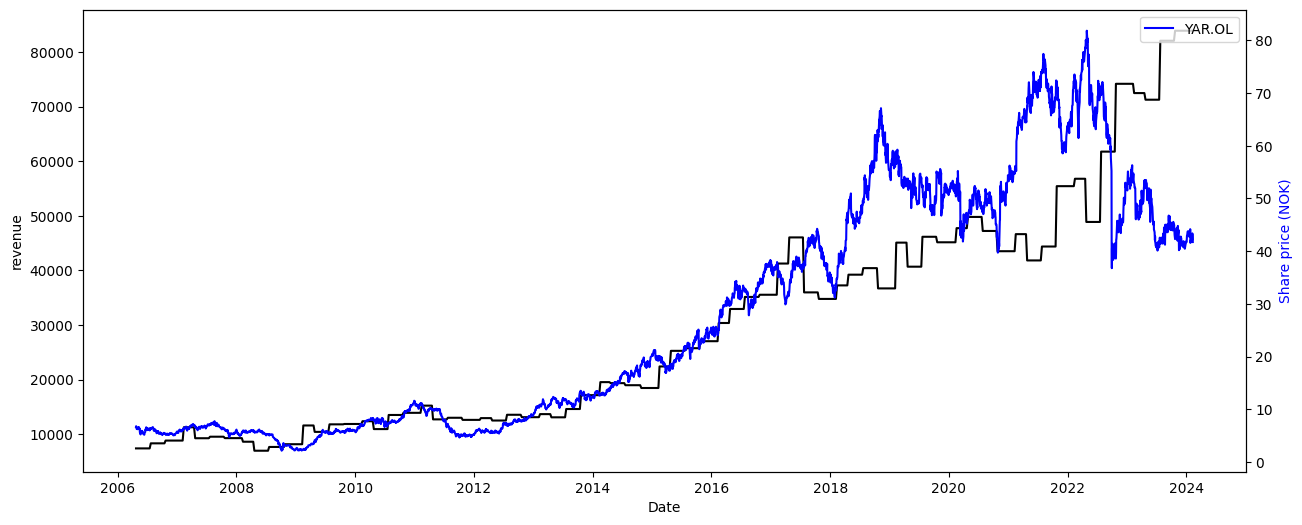

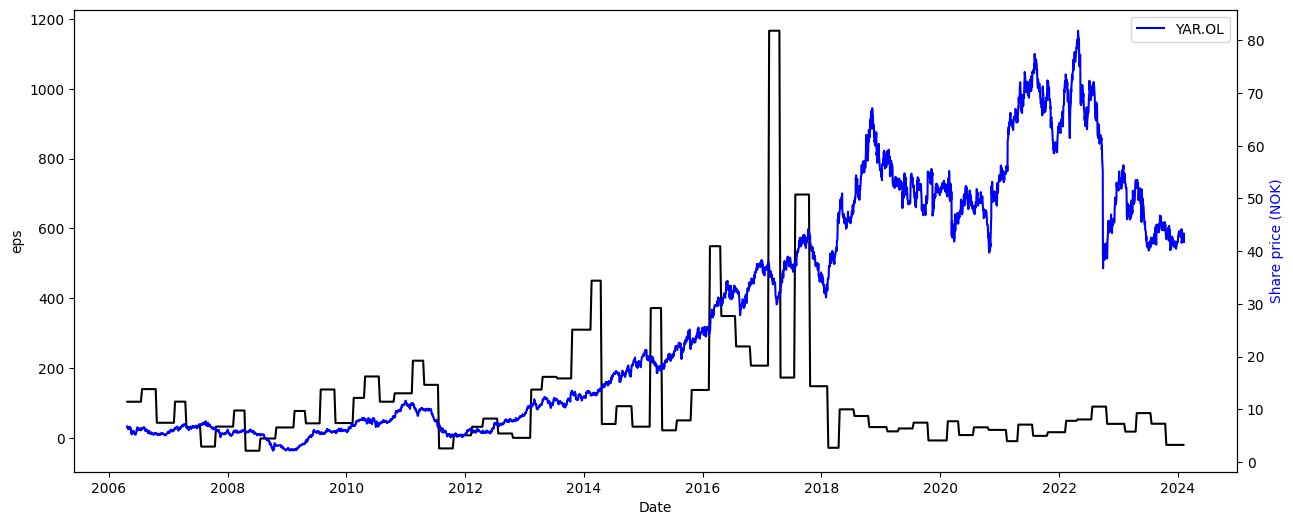

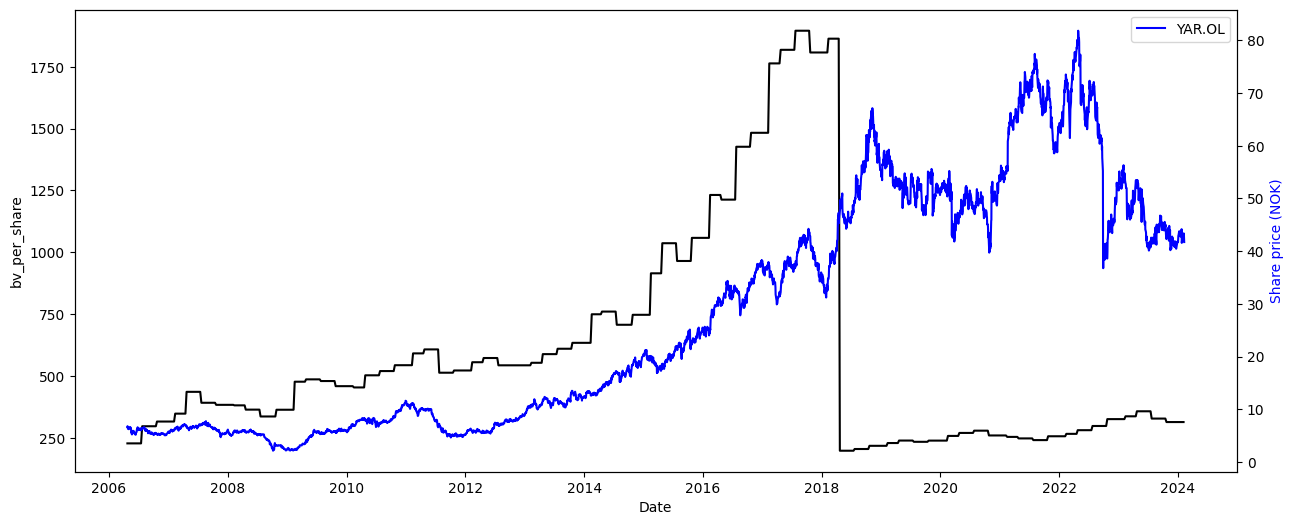

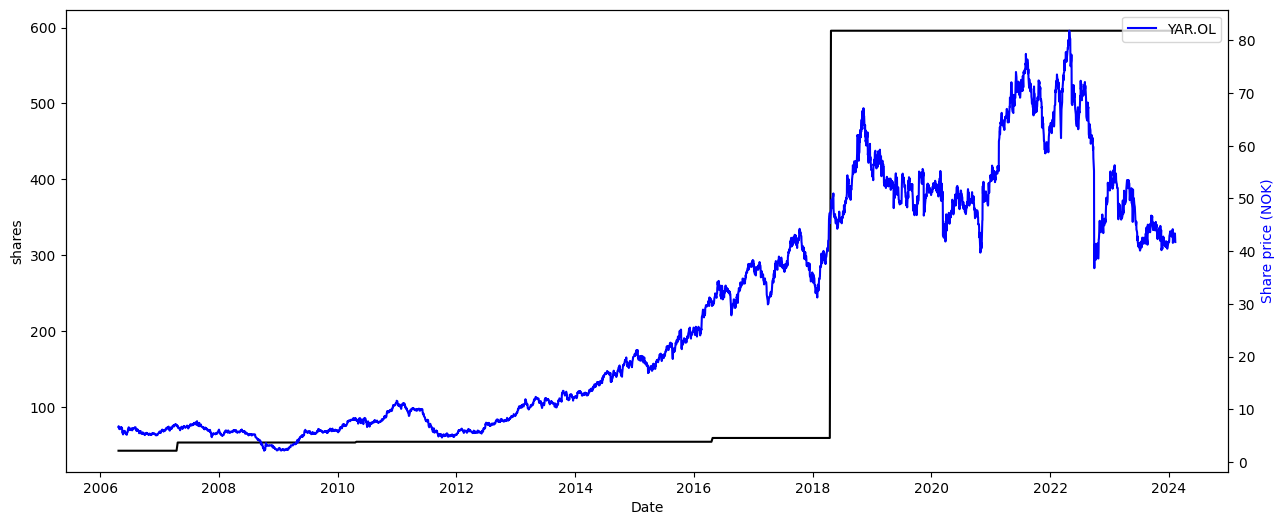

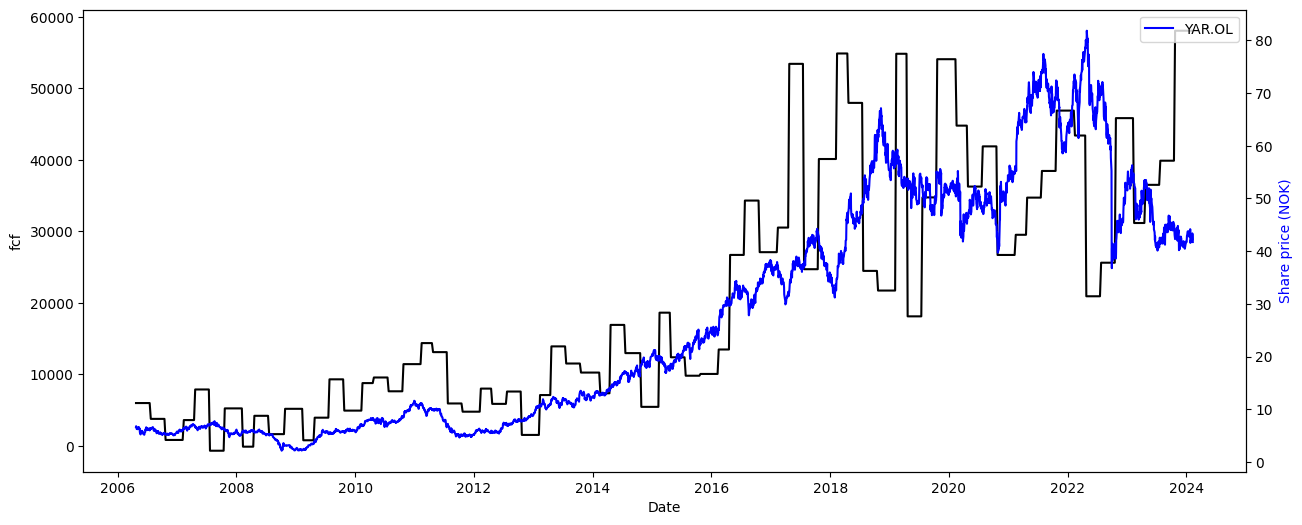

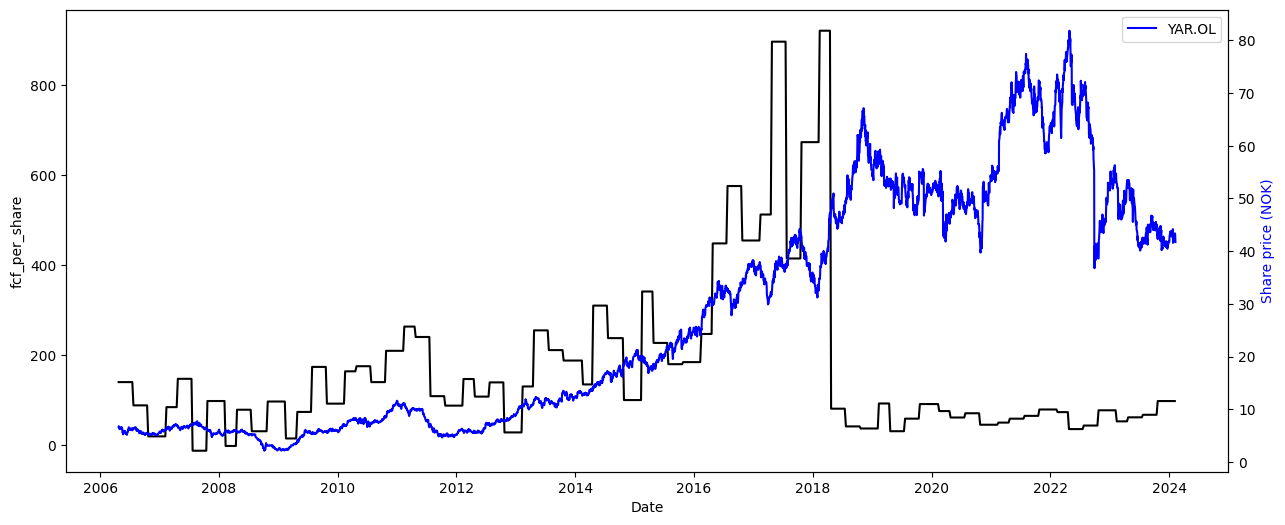

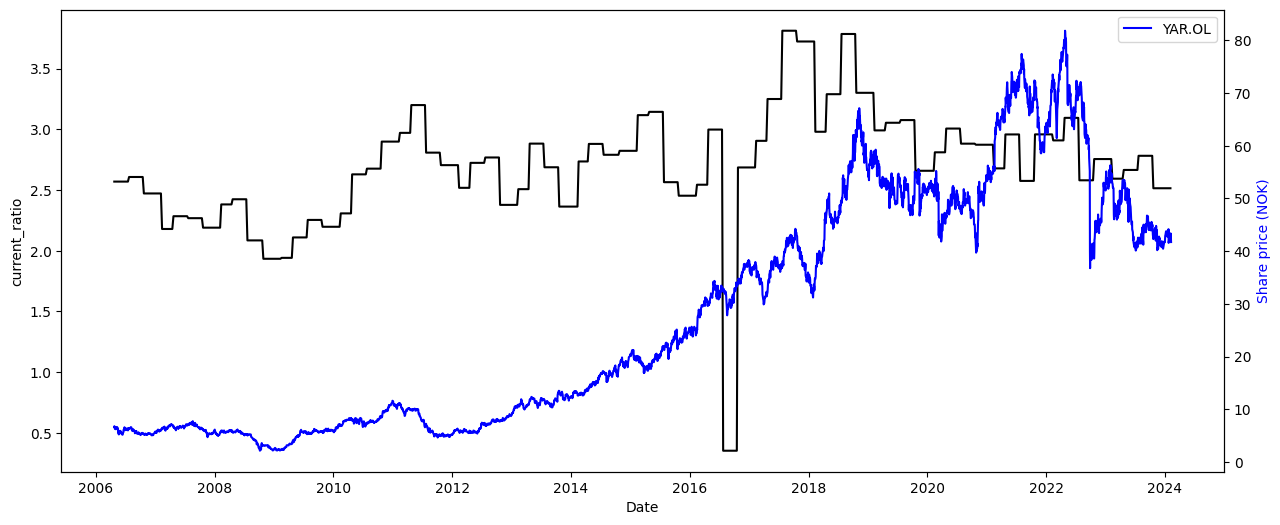

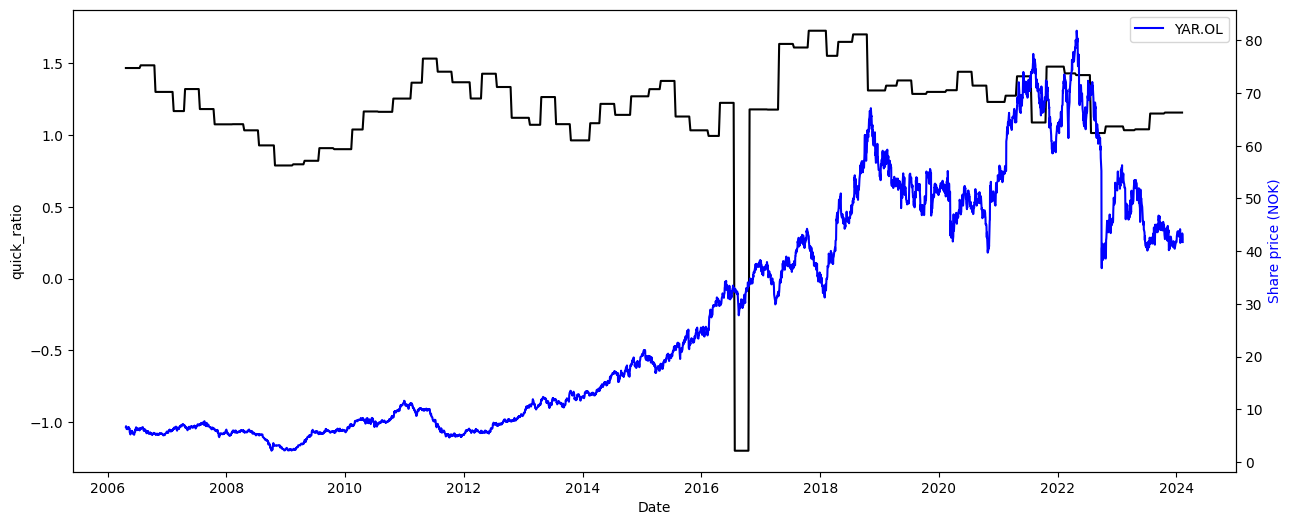

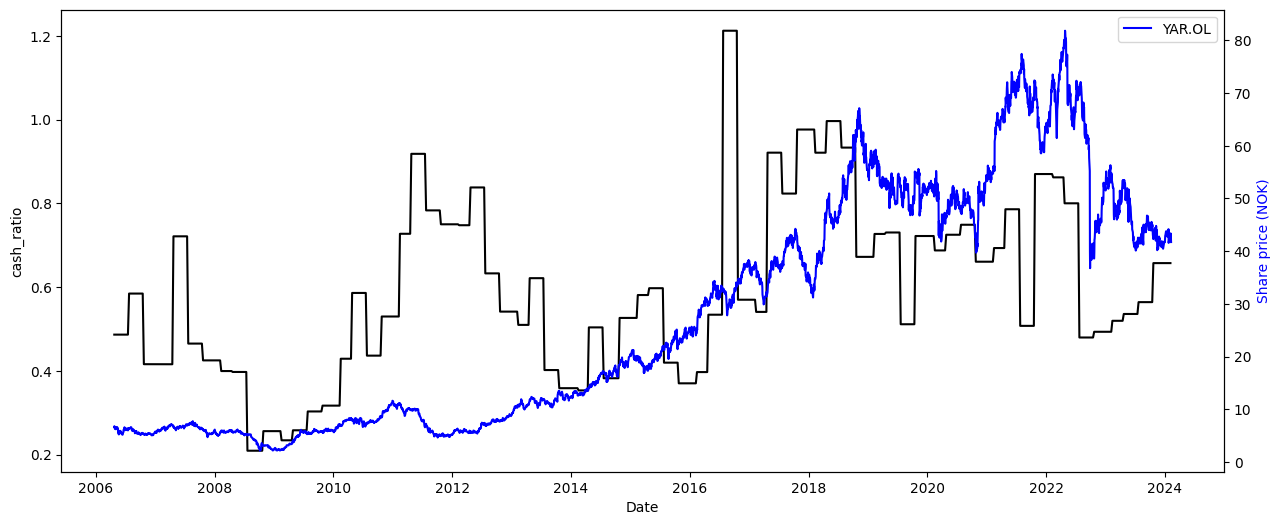

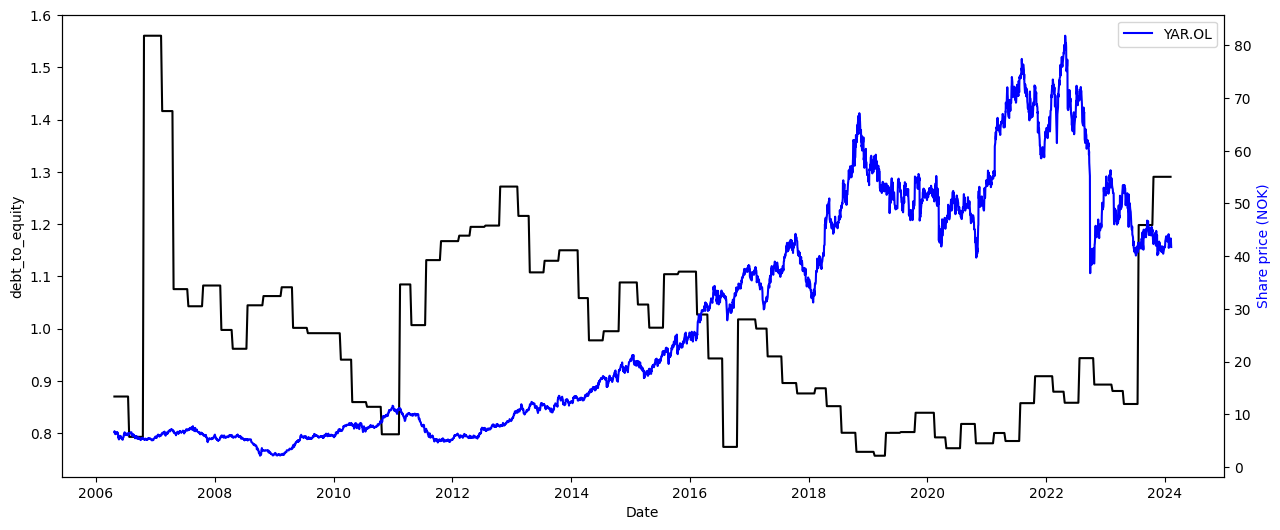

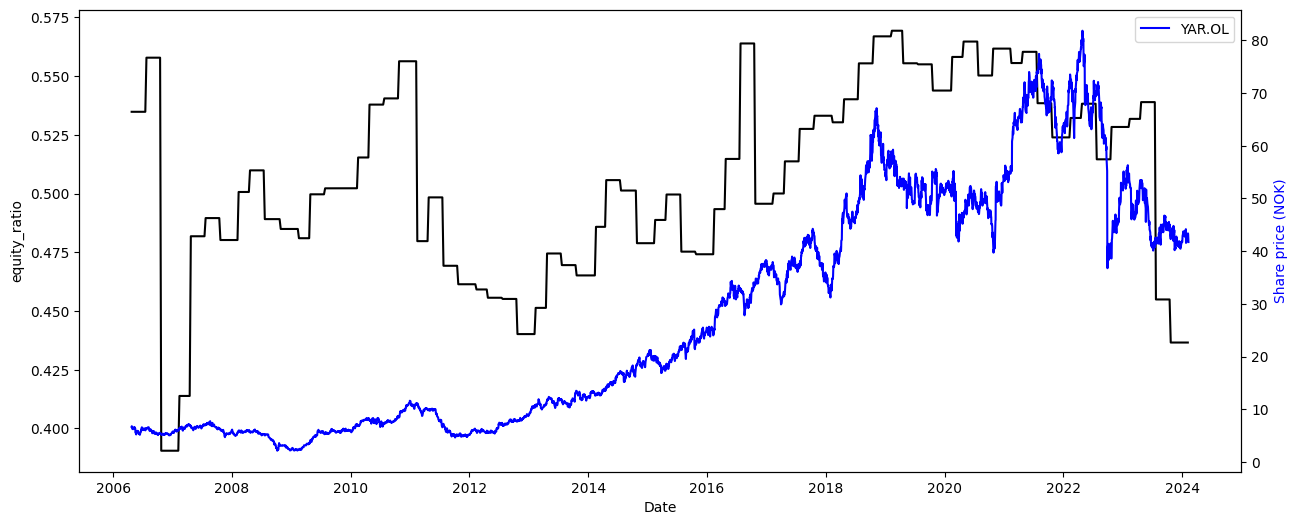

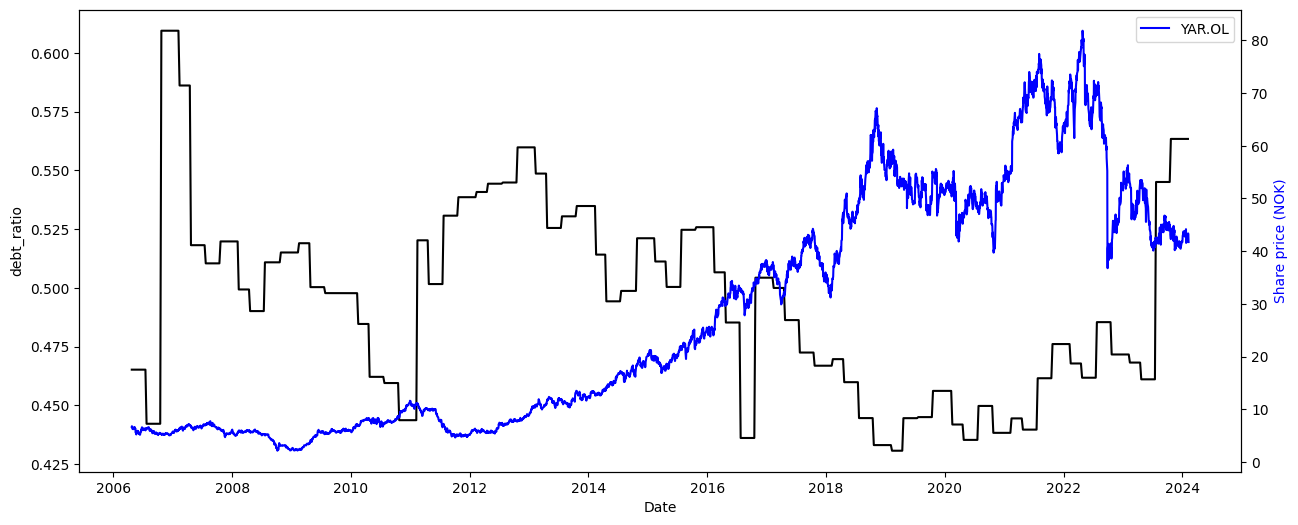

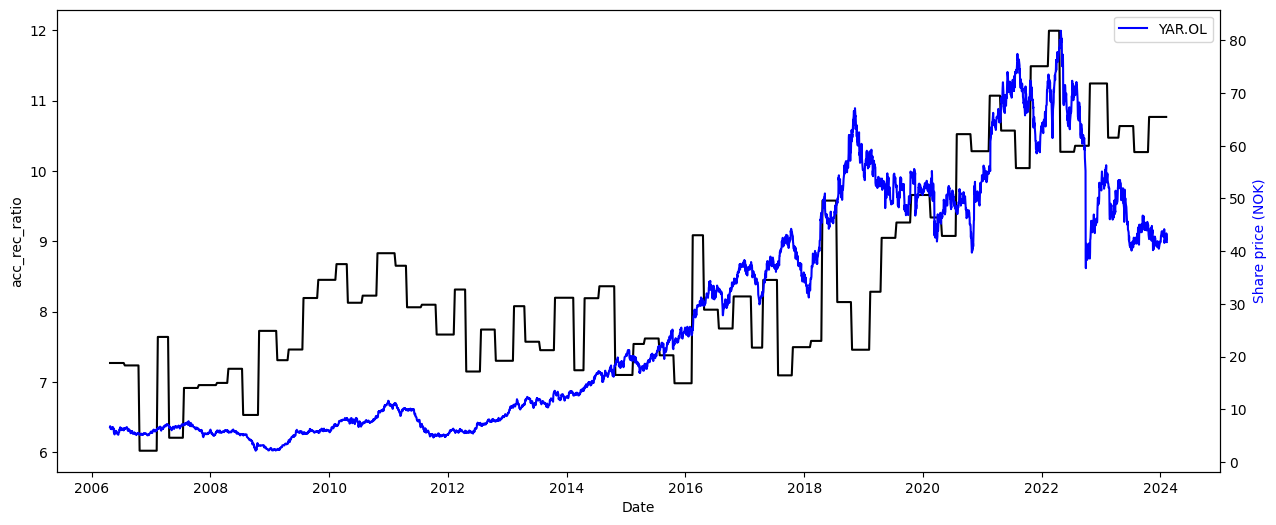

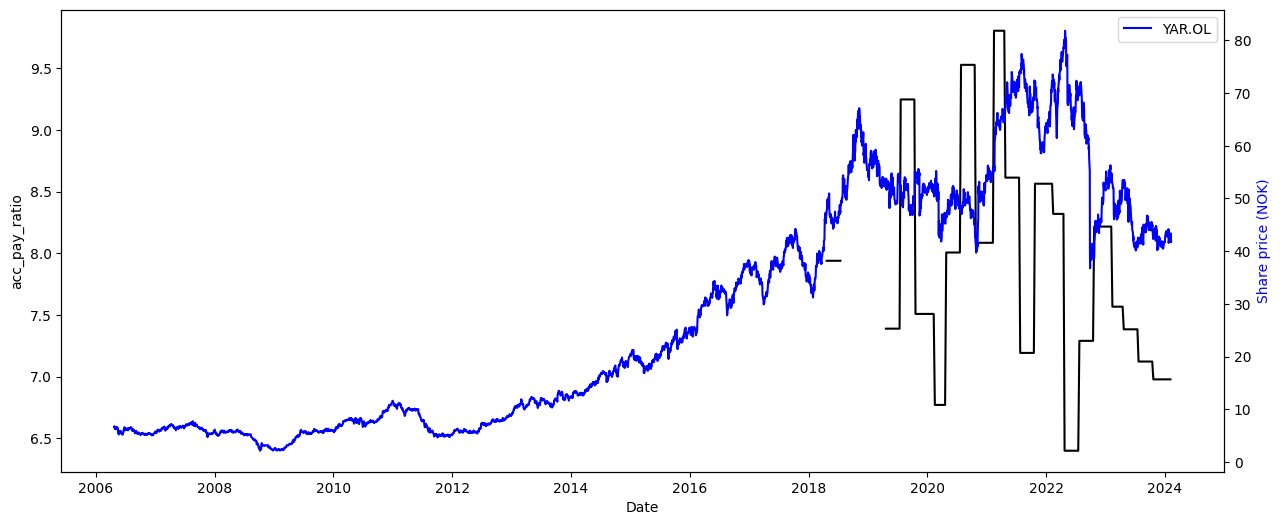

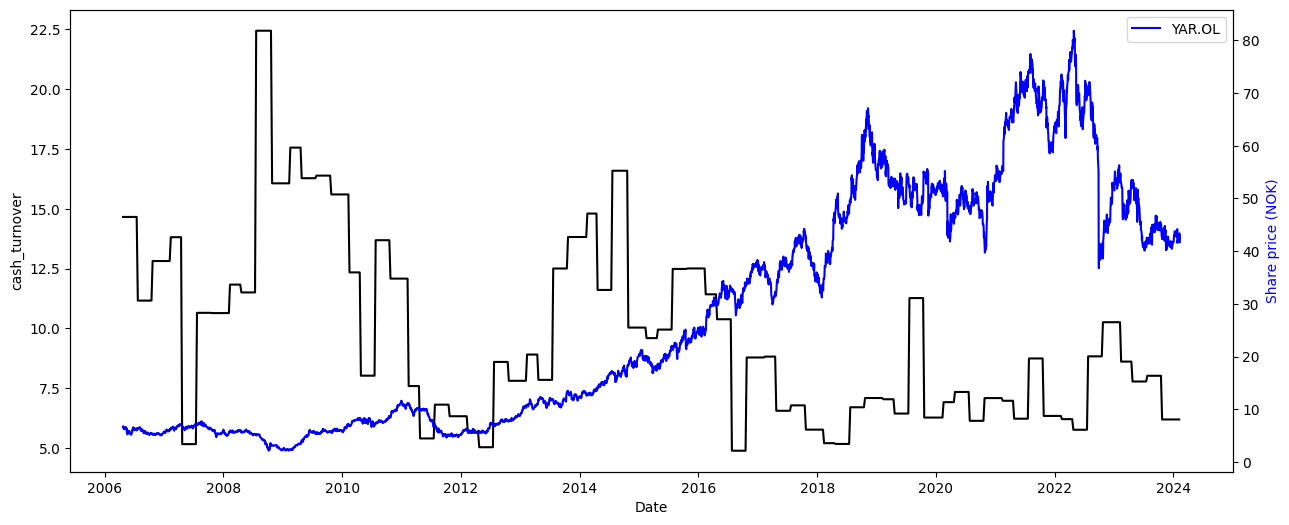

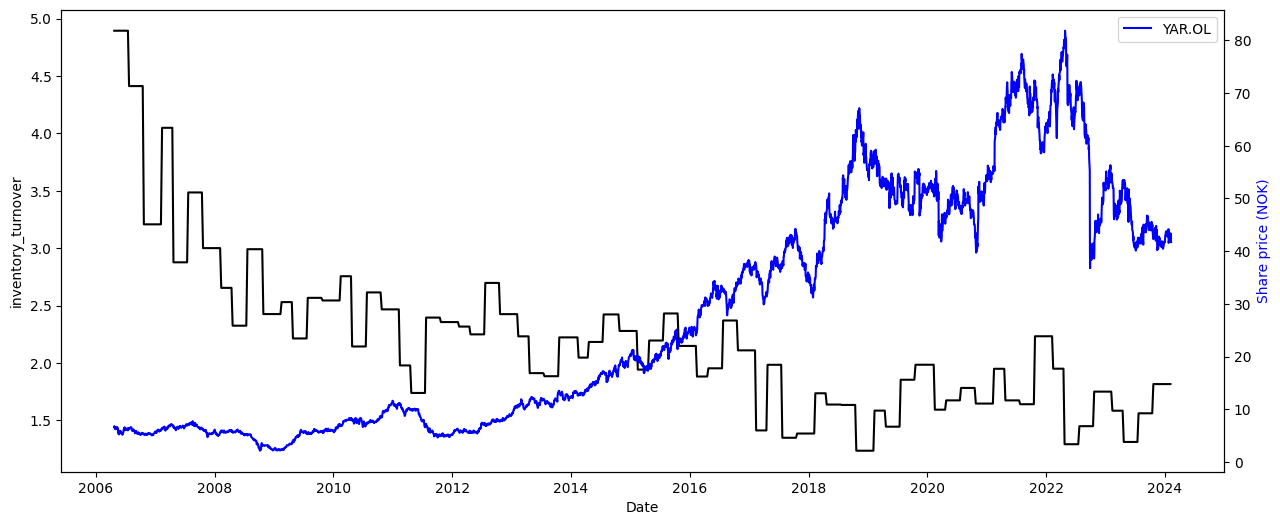

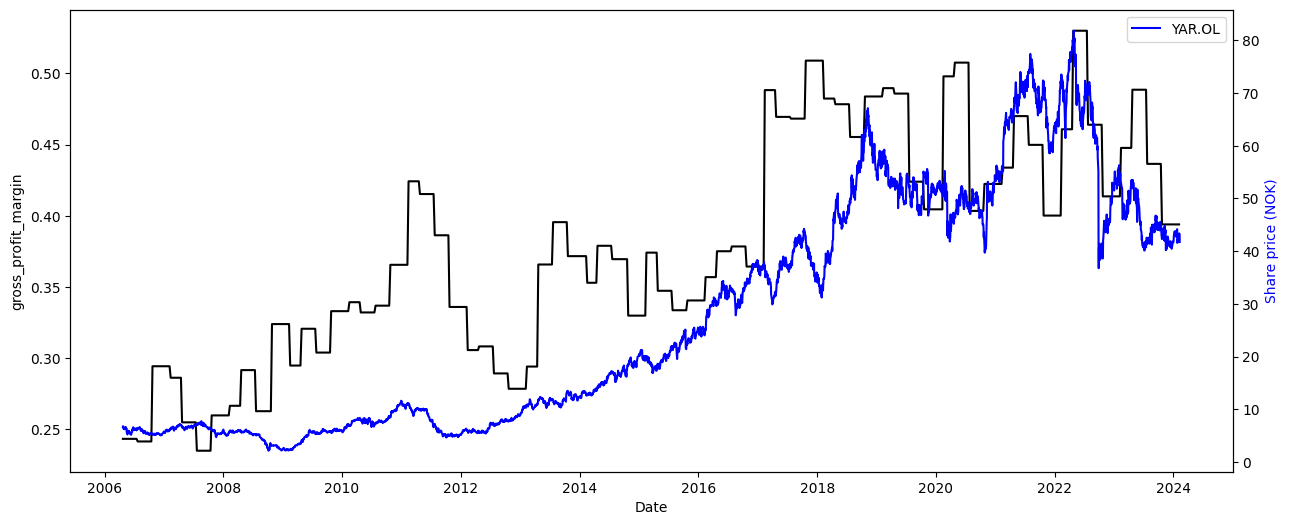

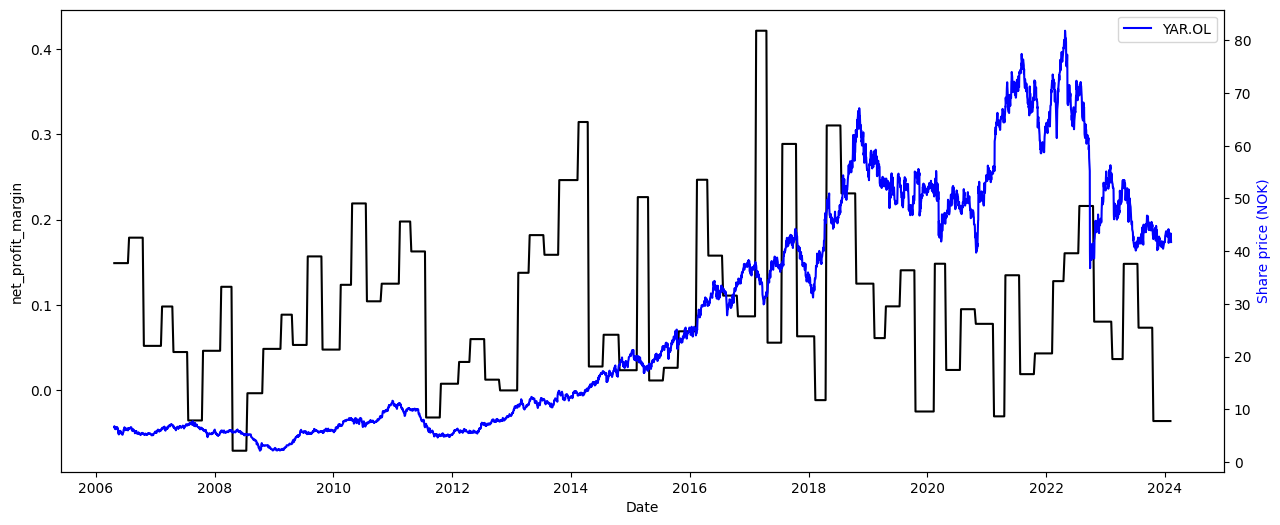

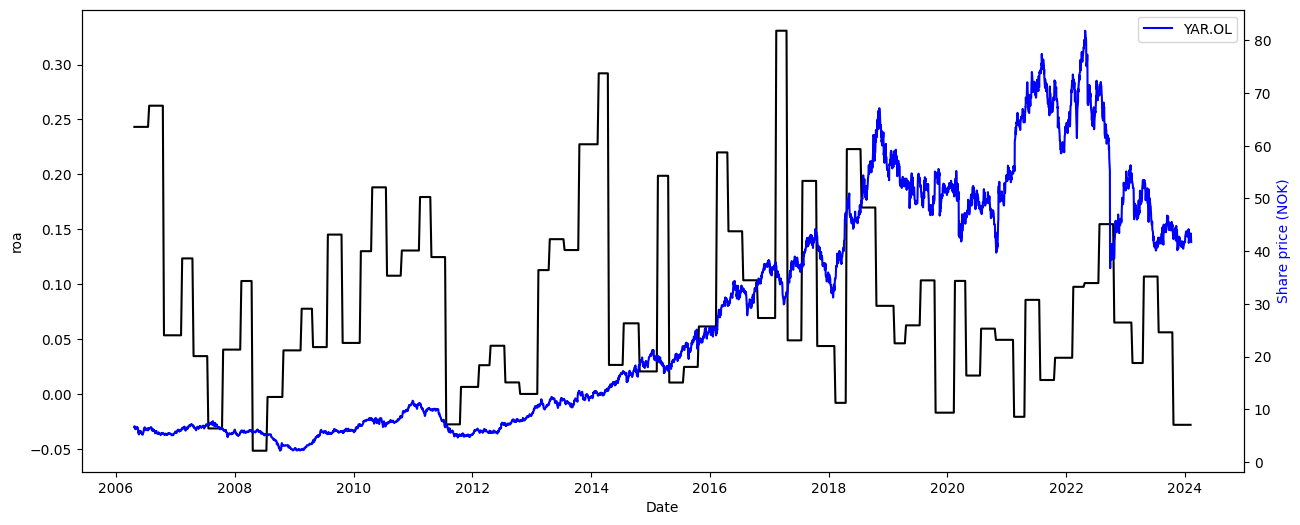

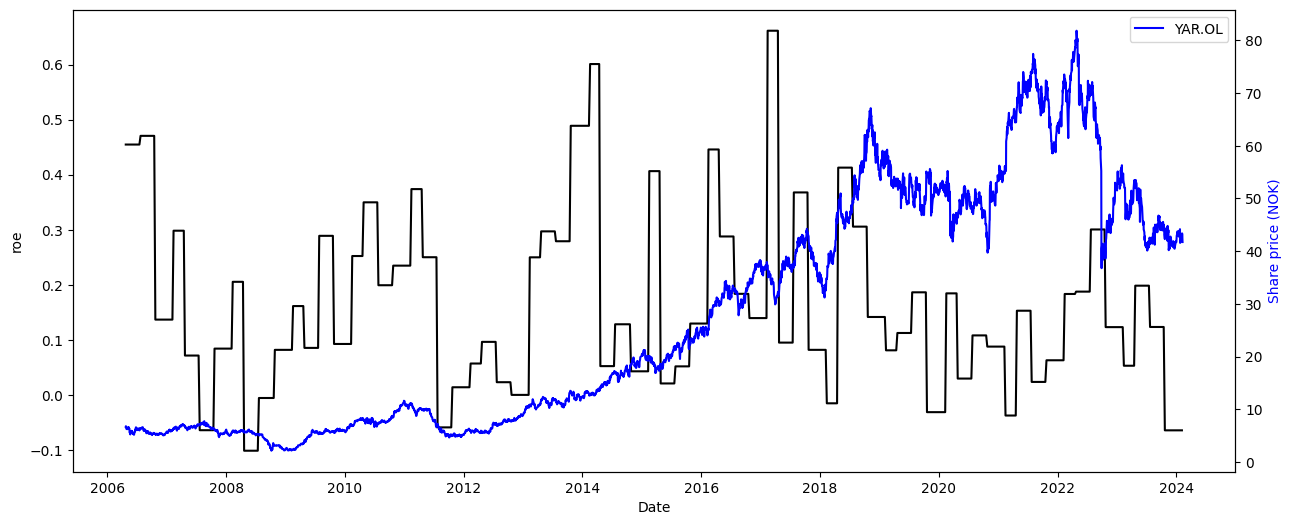

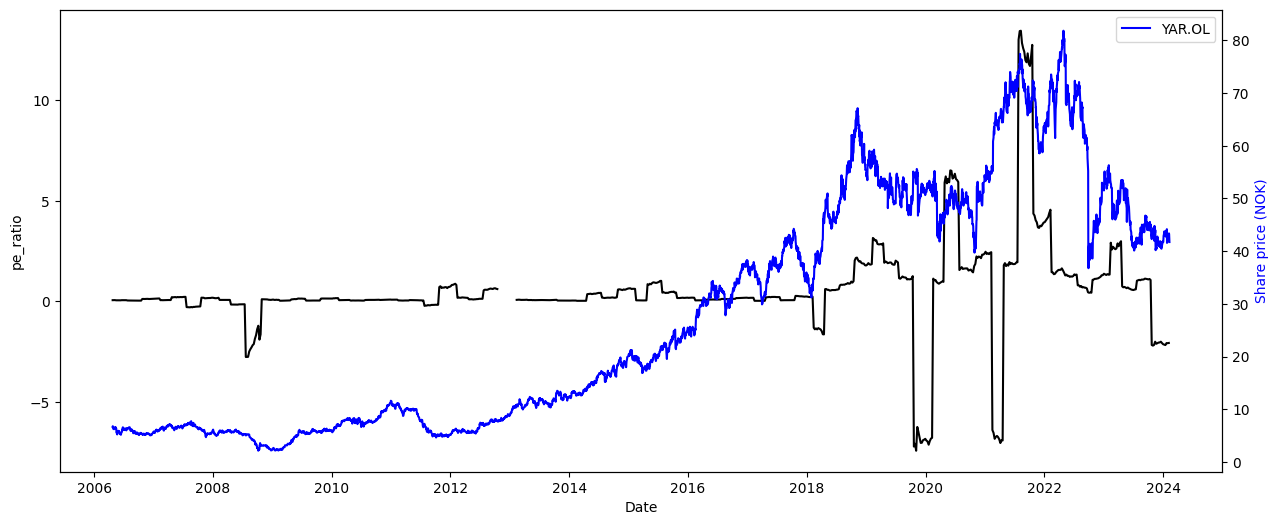

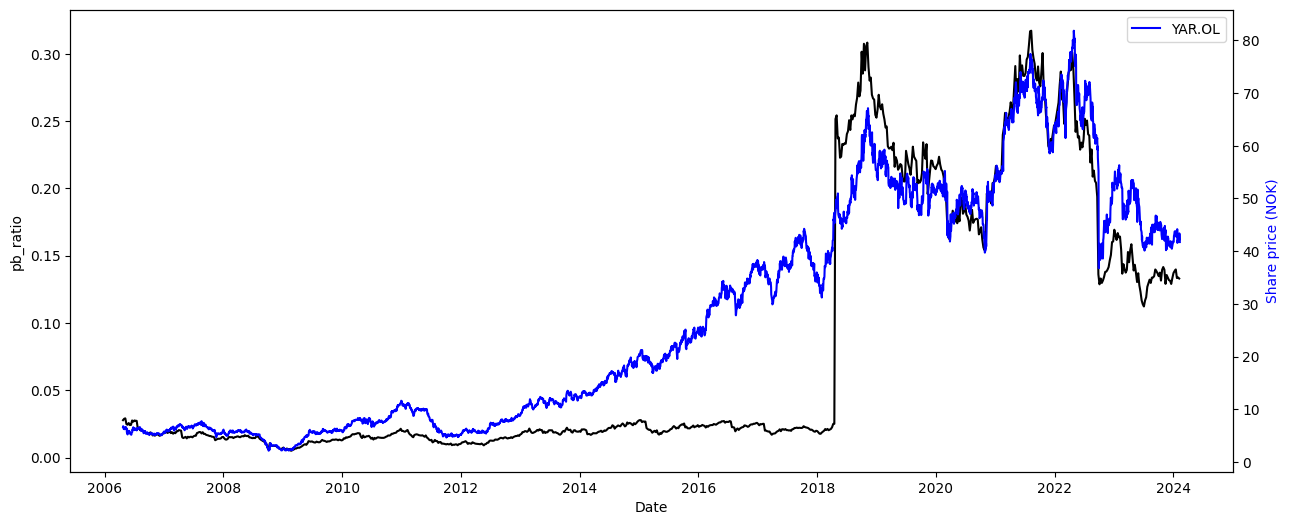

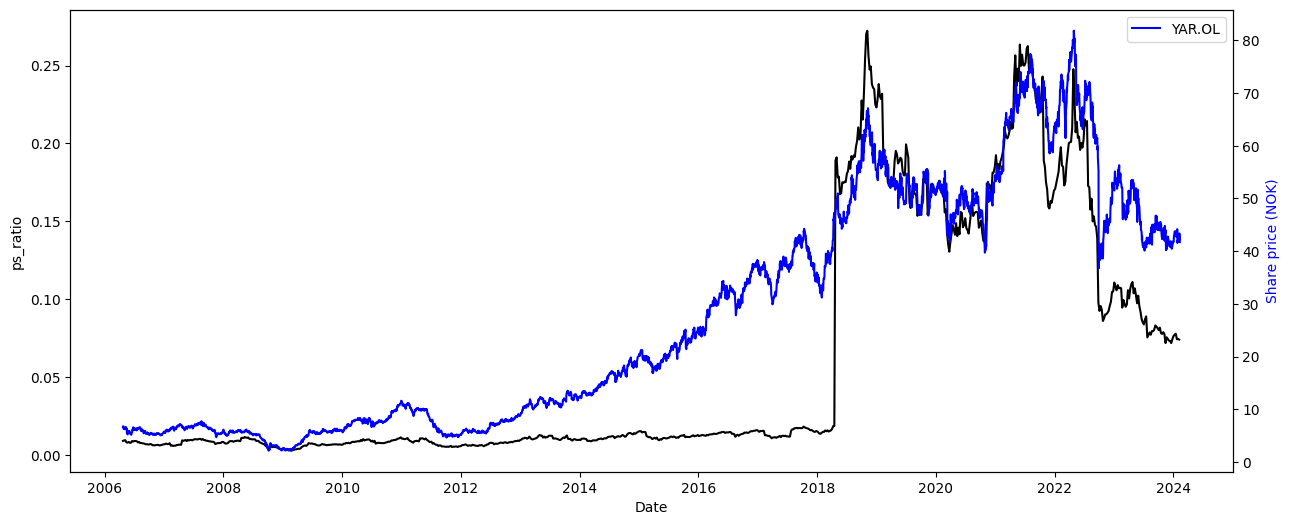

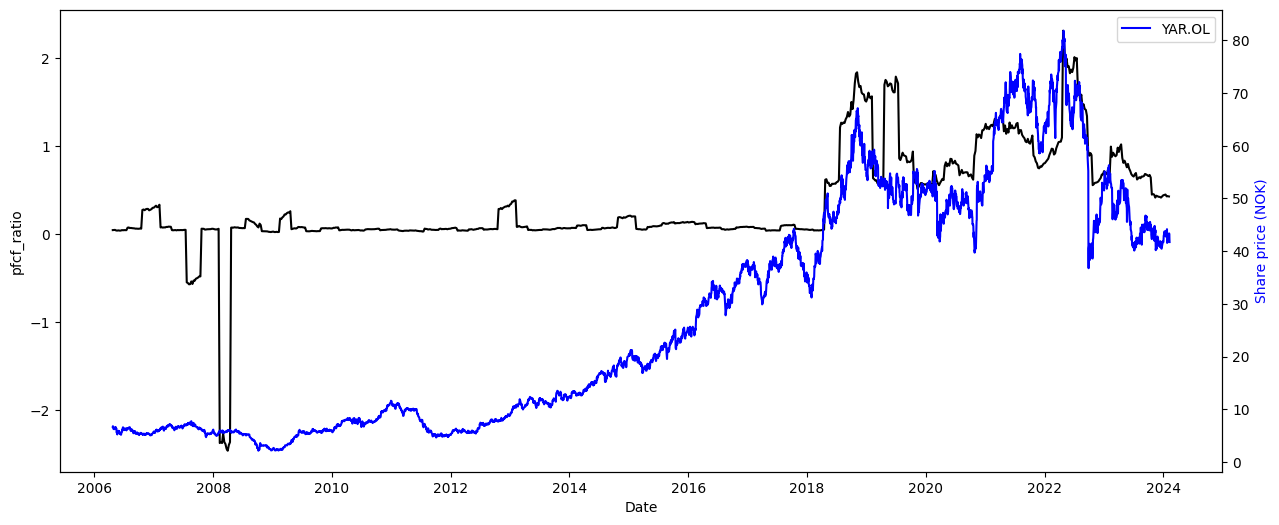

In [87]:
for column in merged_nok.columns[3:]:
    fig, ax1 = plt.subplots(figsize=(15, 6))

    ax2 = ax1.twinx()
    ax1.plot(merged_nok['real_date'], merged_nok[column], color='k', label=merged_nok)
    ax2.plot(yar_all_price.index, yar_all_price['Close'], color='b', label='YAR.OL')

    ax1.set_xlabel('Date')
    ax1.set_ylabel(column, color='k')
    ax2.set_ylabel('Share price (NOK)', color='b')

    plt.legend()
    plt.show()

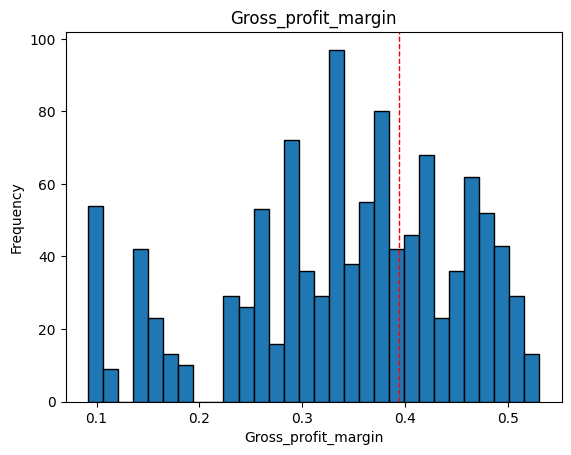

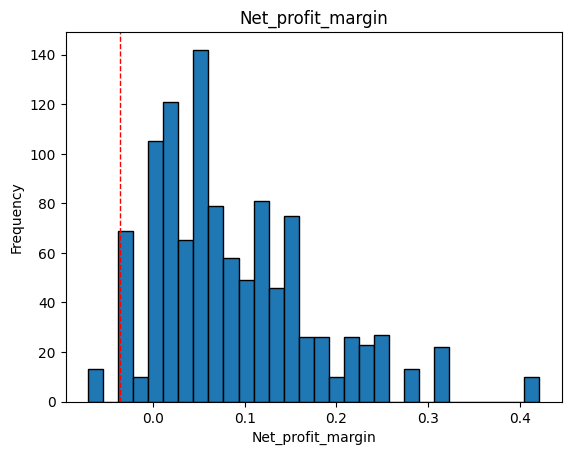

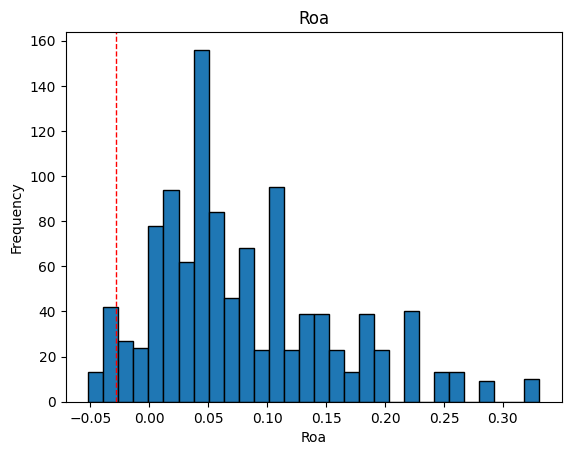

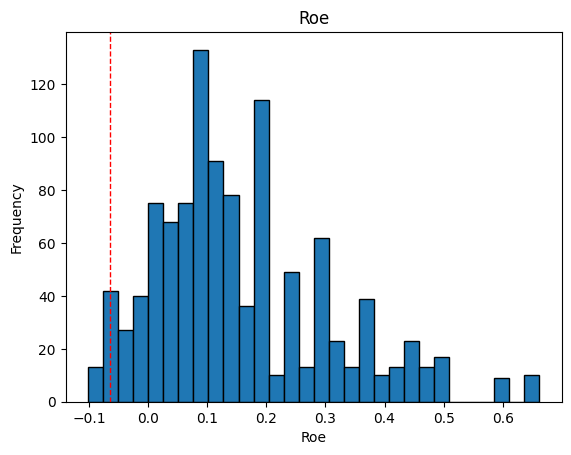

pe_ratio diagram is missing due to error.


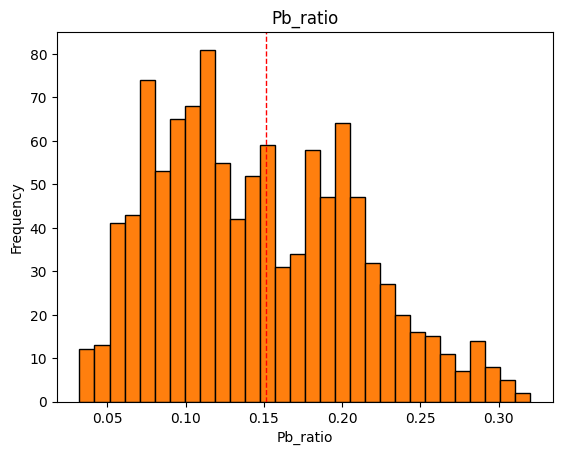

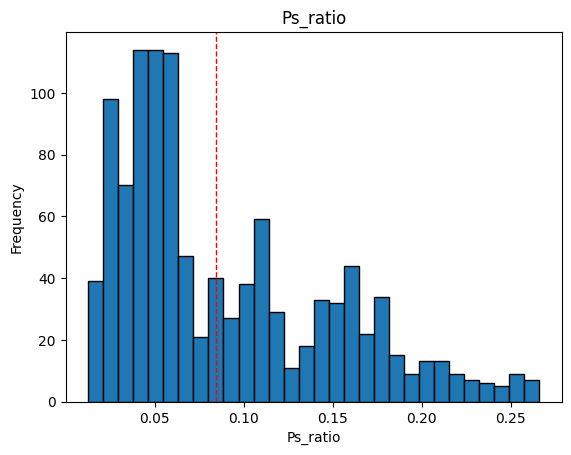

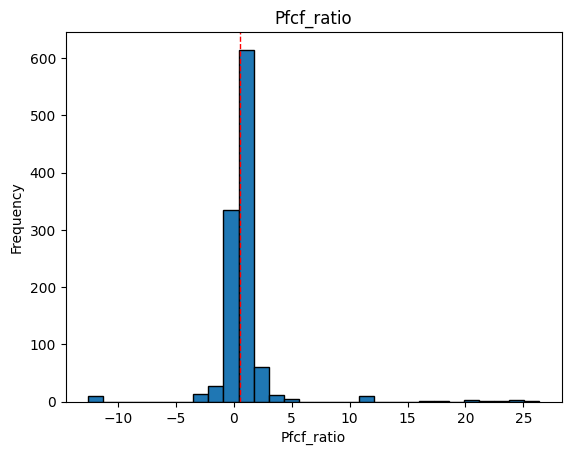

In [ ]:
for column in merged_nok.columns[-8:]:
    try:
        plt.hist(merged_nok[column].values, bins=30, edgecolor='black')
        plt.axvline(merged_nok[column].iloc[-1], color='r', linestyle='dashed', linewidth=1)
        
        plt.xlabel(column.capitalize())
        plt.ylabel('Frequency')
        plt.title(column.capitalize())
        
        plt.show()
    except:
        print(column + " diagram is missing due to error.")